<h1 style="font-size:3em;">The Hopf model</h1>

<h1 style="font-size:1em;">The Hopf model describes the complex-plane motion of membrane potentials x and y of a single neuronal population (or local brain area) with a pair of mutually coupled linear–nonlinear differential equations: when the bifurcation parameter a is negative the origin is a stable focus and the population remains silent, whereas for a>0 the origin loses stability and a limit cycle emerges, so the population oscillates persistently at frequency ω.</h1>

In [ ]:
import brainstate
import braintools
import matplotlib.pyplot as plt
import numpy as np
import brainmass
import jax.numpy as jnp

In [ ]:
from datasets import Dataset
plt.rcParams['image.cmap'] = 'plasma'

In [ ]:
brainstate.environ.set(dt=0.1)

<h1 style="font-size:2em;">Single node simulation</h1>

In [ ]:
node = brainmass.HopfModel(
    1,                                    # single ndoe
    a=0.25, w=0.2, β=1.0,                 
    noise_x=brainmass.OUProcess(1, sigma=0.01),
    noise_y=brainmass.OUProcess(1, sigma=0.01),
)

brainstate.nn.init_all_states(node)
def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return node.update(coupled_x=0., coupled_y=0.)
    
indices = np.arange(10000)                 
x_trace, y_trace = brainstate.transform.for_loop(step_run, indices)

In [ ]:
t_ms = indices * brainstate.environ.get_dt()
plt.figure(figsize=(6, 3))
plt.plot(t_ms, x_trace[:, 0], label='x(t)')
plt.plot(t_ms, y_trace[:, 0], label='y(t)')
plt.xlabel('time (ms)')
plt.ylabel('Activity')
plt.title('Single Hopf oscillator with OU noise')
plt.legend()
plt.tight_layout()
plt.show()

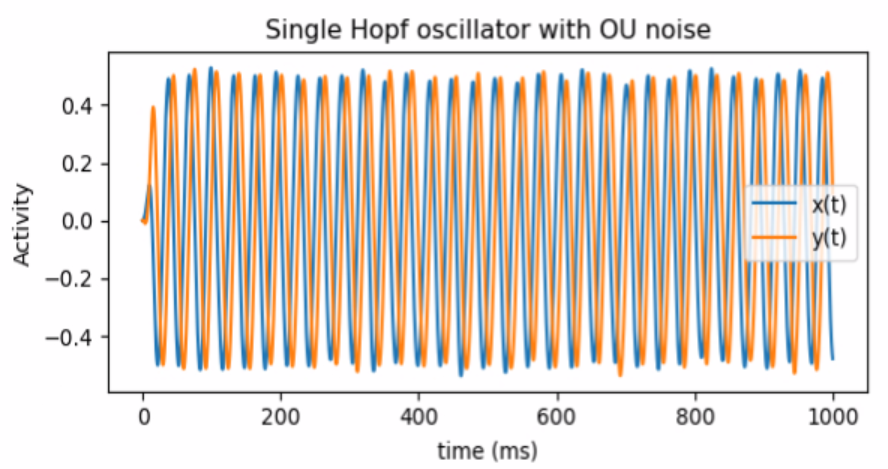

<h1 style="font-size:2em;">Bifurcation diagram</h1>

In [ ]:
a_vals = np.linspace(-2, 2, 50)          # 50 points

nodes = brainmass.HopfModel(
    a_vals.size,
    a=a_vals,               # 每个节点对应一个 a
    w=0.2,
    β=1.0,
    noise_x=brainmass.OUProcess(a_vals.size, sigma=0.01),
    noise_y=brainmass.OUProcess(a_vals.size, sigma=0.01),
)
brainstate.nn.init_all_states(nodes)

def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return nodes.update(coupled_x=0., coupled_y=0.)
    
indices = np.arange(200000)                    
x_trace, _ = brainstate.transform.for_loop(step_run, indices)
x_last = x_trace[-50000:]                      # shape (5000, 50)
max_x = x_last.max(axis=0)
min_x = x_last.min(axis=0)

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(a_vals, max_x, c='k', lw=2, label='max x')
plt.plot(a_vals, min_x, c='k', lw=2, label='min x')
plt.axvline(0.0, ls='--', color='gray')
plt.title('Hopf bifurcation diagram')
plt.xlabel('bifurcation parameter a')
plt.ylabel('max / min x')
plt.legend()
plt.tight_layout()
plt.show()

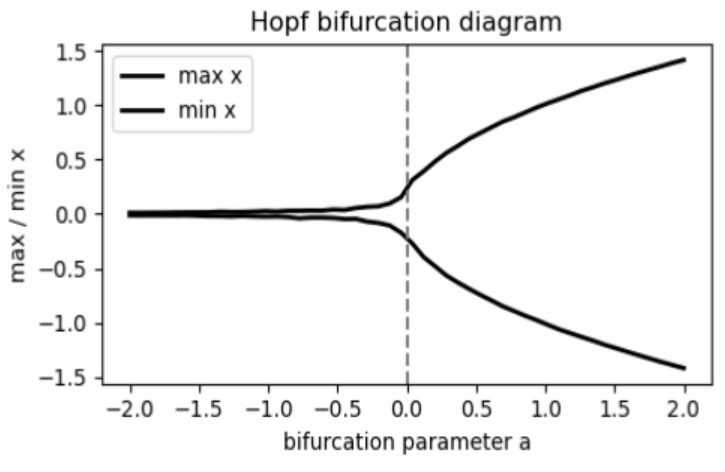

<h1 style="font-size:2em;">Brain network</h1>

In [ ]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2.):
        super().__init__()

        hcp = Dataset('hcp')
        conn_weight = hcp.Cmat
        np.fill_diagonal(conn_weight, 0)
        delay_time = hcp.Dmat / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.tile(np.arange(conn_weight.shape[1]), conn_weight.shape[0])

        self.node = brainmass.HopfModel(
            80,
            noise_x=brainmass.OUProcess(80, sigma=0.01),
            noise_y=brainmass.OUProcess(80, sigma=0.01),
        )

        self.coupling_x = brainmass.HopfCoupling(
            self.node.prefetch_delay('x',  (delay_time.flatten(), indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('x'),
            conn_weight,
            K = 1.0
        )

        self.coupling_y = brainmass.HopfCoupling(
            self.node.prefetch_delay('y',   (delay_time.flatten(), indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('y'),
            conn_weight,
            K = 0.6
        )

    def update(self):
        coupled_x = self.coupling_x()
        coupled_y = self.coupling_y()
        x, y = self.node.update(coupled_x=coupled_x, coupled_y=coupled_y)        
        return x, y

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

In [ ]:
# Run the simulation
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, 6e3 // brainstate.environ.get_dt())

exes_tuple = brainstate.transform.for_loop(net.step_run, indices)
exes_x = exes_tuple[0]
exes_y = exes_tuple[1]

In [ ]:
# Visualization
plt.rcParams['image.cmap'] = 'plasma'
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes_x)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices, exes_x[:, ::5], alpha=0.8)
plt.show()        

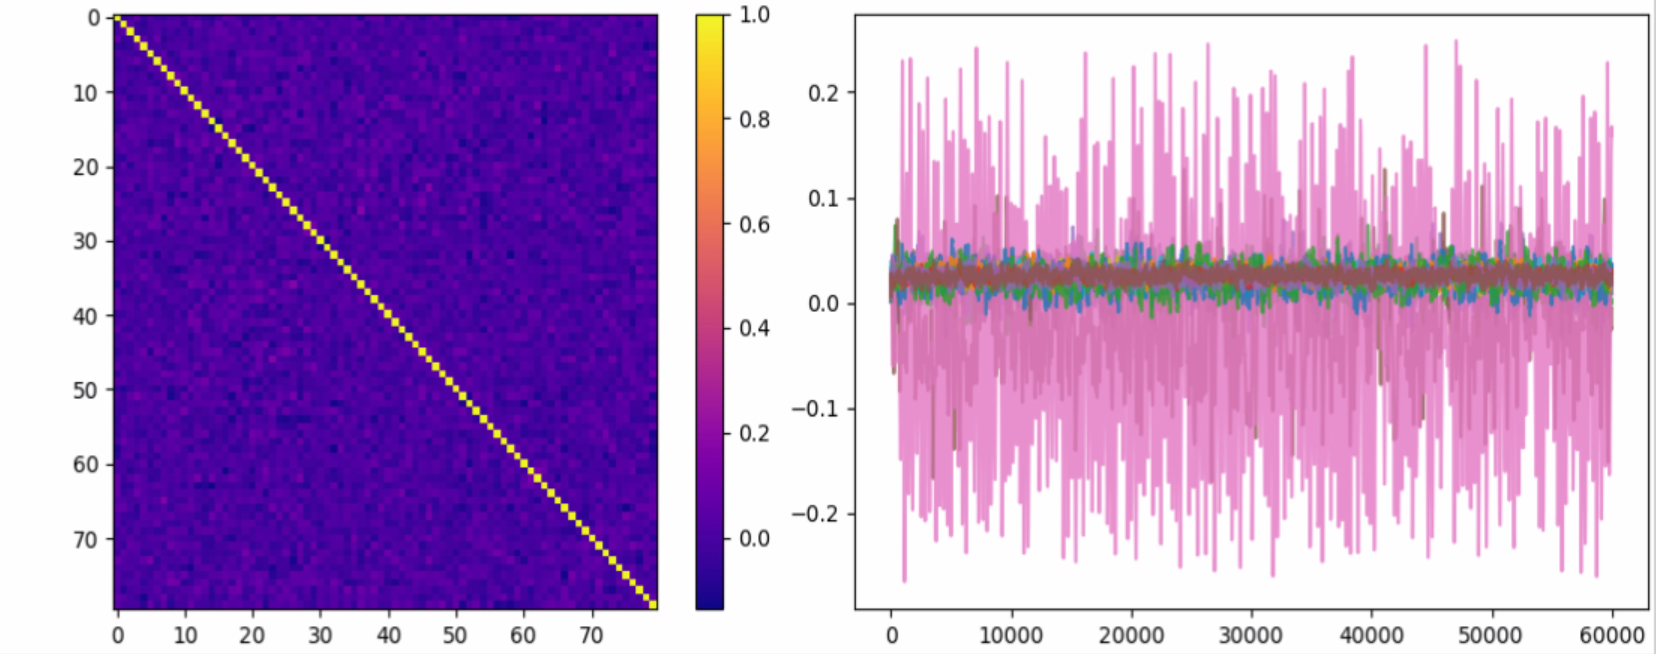